In [ ]:
# Install required libraries (run this cell if not already installed)
!pip install earthengine-api geemap ipywidgets
import ee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.8 MB/s eta 0:00:00


In [ ]:
cloud_project = 'refined-kite-414512'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

In [ ]:
import matplotlib.colors as mcolors
import numpy as np
import ipywidgets as widgets
import geemap
import matplotlib.pyplot as plt

In [ ]:
# Define Pune geometry (20 km buffer to match your LST dataset)
pune_point = ee.Geometry.Point([73.8567, 18.5204])
pune_area = pune_point.buffer(20000).bounds()

# Custom color palette for plotting
colors = ['#313695', '#4575b4', '#74add1', '#abd9e9', '#e0f3f8',
          '#fee090', '#fdae61', '#f46d43', '#d73027', '#a50026']
cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors, N=51)
norm = mcolors.BoundaryNorm(np.arange(0, 52, 1), ncolors=51)

def fetch_lst_image(year, month, return_kelvin=False):
    """
    Fetch the monthly mean MODIS LST image for Pune.

    Parameters:
      - year (int): Year of interest.
      - month (int): Month of interest.
      - return_kelvin (bool): If True, return raw LST in Kelvin;
                              otherwise convert to Celsius.

    Returns:
      - ee.Image: The monthly averaged LST image clipped to the Pune area.
    """
    # Define start and end dates for the month
    start_date = f'{year}-{month:02d}-01'
    end_date = f'{year}-{month+1:02d}-01' if month < 12 else f'{year+1}-01-01'

    dataset = ee.ImageCollection('MODIS/061/MOD11A2') \
        .filterDate(start_date, end_date) \
        .filterBounds(pune_area)

    if return_kelvin:
        # Process the LST in Kelvin
        def convert_to_lst(img):
            return img.select('LST_Day_1km') \
                      .multiply(0.02) \
                      .rename('LST_K') \
                      .copyProperties(img, ['system:time_start'])
    else:
        # Convert the LST from Kelvin to Celsius
        def convert_to_lst(img):
            return img.select('LST_Day_1km') \
                      .multiply(0.02) \
                      .subtract(273.15) \
                      .rename('LST_C') \
                      .copyProperties(img, ['system:time_start'])

    lst_image = dataset.map(convert_to_lst).mean().clip(pune_area)
    return lst_image

# Global dictionary to store LST data as NumPy arrays.
lst_dataset = {}

def process_lst_data(year, month, use_kelvin=False):
    """
    Fetch the LST image from Earth Engine, convert it to a NumPy array,
    store it in a global variable, and plot the image.

    Parameters:
      - year (int): Year.
      - month (int): Month.
      - use_kelvin (bool): If True, process the image in Kelvin.
    """
    print(f"Processing LST image for {month:02d}/{year} with use_kelvin={use_kelvin}...")
    ee_img = fetch_lst_image(year, month, return_kelvin=use_kelvin)# Fetch the Earth Engine image.


    # Convert the image to a NumPy array.
    arr = geemap.ee_to_numpy(ee_img, region=pune_area, scale=1000)
    arr = np.squeeze(arr)

    # Save to global variable using a key that includes the conversion mode.
    key = f"{year}_{month:02d}_{'K' if use_kelvin else 'C'}"
    lst_dataset[key] = arr
    print(f"Data stored in variable 'lst_dataset' under key '{key}'.")

    # Plotting the image.
    plt.figure(figsize=(10, 8))
    if use_kelvin:
        # Adjust normalization for Kelvin (example range)
        kelvin_norm = mcolors.Normalize(vmin=290, vmax=320)
        img = plt.imshow(arr, cmap=cmap, norm=kelvin_norm)
        plt.title(f"LST Image (K) - {month:02d}/{year}")
    else:
        img = plt.imshow(arr, cmap=cmap, norm=norm)
        plt.title(f"LST Image (°C) - {month:02d}/{year}")
    plt.axis('off')
    cbar = plt.colorbar(img, fraction=0.046, pad=0.04)
    cbar.set_label('Temperature')
    plt.show()

# Create interactive widgets for year, month, and Kelvin toggle.
year_widget = widgets.IntSlider(value=2010, min=2003, max=2018, step=1, description='Year:')
month_widget = widgets.Dropdown(
    options=[(name, i+1) for i, name in enumerate([
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ])],
    value=1,
    description='Month:'
)
kelvin_toggle = widgets.ToggleButton(
    value=False,
    description='Use Kelvin',
    tooltip='Toggle to process image in Kelvin'
)

# Set up the interactive UI.
ui = widgets.VBox([widgets.HBox([year_widget, month_widget]), kelvin_toggle])
out = widgets.interactive_output(process_lst_data, {'year': year_widget, 'month': month_widget, 'use_kelvin': kelvin_toggle})
display(ui, out)

print("The selected LST image is visualized and stored in the variable 'lst_dataset'.")

Output()

The selected LST image is visualized and stored in the variable 'lst_dataset'.


In [ ]:
# Define Pune geometry (20 km buffer to match LST)
pune_point = ee.Geometry.Point([73.8567, 18.5204])
pune_area = pune_point.buffer(20000).bounds()

# Load the annual landcover dataset and create a mosaic.
annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual")
annual_mosaic = annual.mosaic()

# Function to recode class values into sequential values starting from 1
def recode_classes(image):
    classes = [10, 11, 12, 20, 51, 52, 61, 62, 71, 72, 81, 82, 91, 92, 120, 121, 122,
               130, 140, 150, 152, 153, 181, 182, 183, 184, 185, 186, 187, 190, 200,
               201, 202, 210, 220, 0]
    new_values = list(range(1, len(classes) + 1))
    return image.remap(classes, new_values)

# Define a visualization palette (36 colors for 36 classes).
palette = [
  "#ffff64", "#ffff64", "#ffff00", "#aaf0f0", "#4c7300", "#006400", "#a8c800", "#00a000",
  "#005000", "#003c00", "#286400", "#285000", "#a0b432", "#788200", "#966400", "#964b00",
  "#966400", "#ffb432", "#ffdcd2", "#ffebaf", "#ffd278", "#ffebaf", "#00a884", "#73ffdf",
  "#9ebb3b", "#828282", "#f57ab6", "#66cdab", "#444f89", "#c31400", "#fff5d7", "#dcdcdc",
  "#fff5d7", "#0046c8", "#ffffff", "#ffffff"
]
landcover_cmap = mcolors.ListedColormap(palette)
landcover_norm = mcolors.BoundaryNorm(np.arange(1, 38), ncolors=36)

# Global dictionary to store processed landcover data (annual cadence)
landcover_dataset = {}

def process_landcover_data(year):
    """
    Fetch, process, and display the landcover image for the given year.
    For this dataset, band index = year - 1999 (e.g., for year 2003, band 'b4' is used).
    The processed NumPy array is stored in the global dictionary.
    """
    print(f"Processing landcover data for {year}...")
    # If data is already fetched, simply display it.
    if year in landcover_dataset:
        arr = landcover_dataset[year]
        print(f"Data for {year} loaded from variable.")
    else:
        # Compute the band index (band for year 2000 is 'b1')
        band_index = year - 1999
        band_name = 'b' + str(band_index)
        # Select the corresponding band and clip to Pune area.
        image = annual_mosaic.select(band_name).clip(pune_area)
        # Recode the landcover classes to sequential values.
        recoded = recode_classes(image)
        # Convert the Earth Engine image to a NumPy array at 30 m resolution.
        arr = geemap.ee_to_numpy(recoded, region=pune_area, scale=30)
        arr = np.squeeze(arr)
        # Store in the global dictionary.
        landcover_dataset[year] = arr
        print(f"Data for {year} stored in variable.")

    # Plot the landcover image.
    plt.figure(figsize=(8,8))
    img = plt.imshow(arr, cmap=landcover_cmap, norm=landcover_norm)
    plt.title(f"Landcover for {year}")
    plt.axis('off')
    cbar = plt.colorbar(img, fraction=0.046, pad=0.04)
    cbar.set_label('Class Index')
    plt.show()

# Create an interactive slider (using the same style as for LST)
year_slider = widgets.IntSlider(value=2003, min=2003, max=2018, step=1, description='Year:')

# Set up the interactive output widget.
interactive_landcover = widgets.interactive_output(process_landcover_data, {'year': year_slider})

# Display the slider and the output.
display(year_slider, interactive_landcover)

print("Use the slider to view the annual landcover dataset. The data is stored in 'landcover_dataset'.")

IntSlider(value=2003, description='Year:', max=2018, min=2003)

Output()

Use the slider to view the annual landcover dataset. The data is stored in 'landcover_dataset'.


In [ ]:
# Define Pune geometry (using a 20 km buffer)
pune_point = ee.Geometry.Point([73.8567, 18.5204])
pune_area = pune_point.buffer(20000).bounds()

# Global dictionary to store PM2.5 data as NumPy arrays (monthly cadence)
pm25_dataset = {}

def fetch_pm25_image(year, month):
    """
    Fetch the monthly mean PM2.5 image for Pune from the GLOBAL-SATELLITE-PM25/MONTHLY dataset.

    Parameters:
      - year (int): Year of interest.
      - month (int): Month of interest.

    Returns:
      - ee.Image: The monthly mean composite PM2.5 image clipped to the Pune area.
    """
    # Define start and end dates for the month.
    start_date = f"{year}-{month:02d}-01"
    end_date = f"{year}-{month+1:02d}-01" if month < 12 else f"{year+1}-01-01"

    # Load the PM2.5 image collection from the correct dataset.
    pm25_collection = ee.ImageCollection("projects/sat-io/open-datasets/GLOBAL-SATELLITE-PM25/MONTHLY") \
                        .filterDate(start_date, end_date) \
                        .filterBounds(pune_area)

    # Compute the monthly mean composite.
    pm25_image = pm25_collection.mean().clip(pune_area)
    return pm25_image

def plot_pm25_image(pm25_image, title="PM2.5 Image", scale=1000):
    """
    Convert the Earth Engine PM2.5 image to a NumPy array and plot it.
    """
    try:
        # Convert the image to a NumPy array.
        arr = geemap.ee_to_numpy(pm25_image, region=pune_area, scale=scale)
        arr = np.squeeze(arr)

        plt.figure(figsize=(10,8))
        # Display the image using the 'viridis' colormap (adjust if needed)
        img = plt.imshow(arr, cmap='viridis')
        plt.title(title)
        plt.axis('off')
        cbar = plt.colorbar(img, fraction=0.046, pad=0.04)
        cbar.set_label('PM2.5 (µg/m³)')
        plt.show()
    except Exception as e:
        print("Error plotting PM2.5 image:", e)

def process_pm25_data(year, month):
    """
    Fetch the PM2.5 image for the specified month and year,
    convert it to a NumPy array, store it in the global variable,
    and display the image.
    """
    print(f"Processing PM2.5 data for {month:02d}/{year}...")
    # Fetch the Earth Engine image.
    ee_img = fetch_pm25_image(year, month)

    # Convert the image to a NumPy array.
    arr = geemap.ee_to_numpy(ee_img, region=pune_area, scale=1000)
    arr = np.squeeze(arr)

    # Store in the global dictionary using a key "year_month"
    key = f"{year}_{month:02d}"
    pm25_dataset[key] = arr
    print(f"Data stored in pm25_dataset under key '{key}'.")

    # Plot the PM2.5 image.
    plot_pm25_image(ee_img, title=f"PM2.5 - {month:02d}/{year}")

# Create interactive widgets for year and month.
year_widget_pm25 = widgets.IntSlider(value=2010, min=2003, max=2018, step=1, description='Year:')
month_widget_pm25 = widgets.Dropdown(
    options=[(name, i+1) for i, name in enumerate([
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ])],
    value=1,
    description='Month:'
)

# Set up the interactive UI.
ui_pm25 = widgets.HBox([year_widget_pm25, month_widget_pm25])
out_pm25 = widgets.interactive_output(process_pm25_data, {'year': year_widget_pm25, 'month': month_widget_pm25})
display(ui_pm25, out_pm25)

print("Use the widgets to fetch and visualize the PM2.5 dataset. Data is stored in 'pm25_dataset'.")


Output()

Use the widgets to fetch and visualize the PM2.5 dataset. Data is stored in 'pm25_dataset'.


In [ ]:
# # Define Pune geometry (20 km buffer)
# pune_point = ee.Geometry.Point([73.8567, 18.5204])
# pune_area = pune_point.buffer(20000).bounds()

# # Dictionary mapping UHII collection names to their asset IDs.
# uhii_collections = {
#     "AMOD2": "projects/sat-io/open-datasets/UHII/AMOD2",
#     "MOD1":  "projects/sat-io/open-datasets/UHII/MOD1",
#     "MOD2":  "projects/sat-io/open-datasets/UHII/MOD2",
#     "MYD1":  "projects/sat-io/open-datasets/UHII/MYD1",
#     "MYD2":  "projects/sat-io/open-datasets/UHII/MYD2",
#     "SAT":   "projects/sat-io/open-datasets/UHII/SAT",
#     "SMOD2": "projects/sat-io/open-datasets/UHII/SMOD2",
#     "SMYD1": "projects/sat-io/open-datasets/UHII/SMYD1"
# }

# # Global dictionary to store UHII monthly data.
# # Keys will be strings like "MOD1_2010_03" for MOD1 data in March 2010.
# uhii_monthly_dataset = {}

# # Visualization parameters
# vis_params = {
#     'min': 1,
#     'max': 25,
#     'palette': ['#000004', '#1f0c48', '#550f6d', '#88226a',
#                 '#b63655', '#de4968', '#f87d46', '#fdca26', '#f0f921']
# }

# def process_uhii_monthly_data(collection_name, year, month):
#     """
#     For a given UHII collection, year, and month, filter the ImageCollection
#     using calendar-based filters, take the first image (masking out non-positive values),
#     clip it to Pune, convert it to a NumPy array at 300 m resolution,
#     store it in a global dictionary, and display the image.

#     Parameters:
#       - collection_name (str): One of the keys in uhii_collections.
#       - year (int): The year (2003-2018).
#       - month (int): The month (1-12).
#     """
#     print(f"Processing {collection_name} for {year}-{month:02d}...")

#     # Load the collection using its asset ID.
#     asset_id = uhii_collections[collection_name]
#     col = ee.ImageCollection(asset_id)

#     # Filter by year and month using calendarRange filters.
#     filtered = col.filter(ee.Filter.calendarRange(year, year, 'year')) \
#                   .filter(ee.Filter.calendarRange(month, month, 'month')) \
#                   .filterBounds(pune_area)

#     count = filtered.size().getInfo()
#     if count == 0:
#         print(f"No image available for {collection_name} in {year}-{month:02d}.")
#         return

#     # Get the first image and apply a mask: keep pixels where the value > 0.
#     uhi = ee.Image(filtered.first())
#     uhi = uhi.mask(uhi.gt(0)).clip(pune_area)

#     # Convert the image to a NumPy array at 300 m resolution.
#     arr = geemap.ee_to_numpy(uhi, region=pune_area, scale=300)
#     arr = np.squeeze(arr)

#     # Create a key for storage.
#     key = f"{collection_name}_{year}_{month:02d}"
#     uhii_monthly_dataset[key] = arr
#     print(f"Data stored under key '{key}'.")

#     # Plot the image.
#     plt.figure(figsize=(10,8))
#     img = plt.imshow(arr, cmap='inferno', vmin=vis_params['min'], vmax=vis_params['max'])
#     plt.title(f"UHII {collection_name} - {year}-{month:02d}")
#     plt.axis("off")
#     cbar = plt.colorbar(img, fraction=0.046, pad=0.04)
#     cbar.set_label("UHII Intensity")
#     plt.show()

# # Create interactive widgets.
# collection_widget = widgets.Dropdown(
#     options=list(uhii_collections.keys()),
#     value="AMOD2",
#     description="Collection:"
# )
# year_widget = widgets.IntSlider(value=2010, min=2003, max=2018, step=1, description="Year:")
# month_widget = widgets.Dropdown(
#     options=[(name, i) for i, name in enumerate(
#         ['January','February','March','April','May','June',
#          'July','August','September','October','November','December'], start=1)],
#     value=1,
#     description="Month:"
# )

# # Set up interactive output.
# ui = widgets.VBox([widgets.HBox([collection_widget, year_widget, month_widget])])
# out = widgets.interactive_output(process_uhii_monthly_data,
#                                  {'collection_name': collection_widget,
#                                   'year': year_widget,
#                                   'month': month_widget})
# display(ui, out)

# print("Use the widgets to fetch and visualize UHII monthly data from 2003 to 2018. Data is stored in 'uhii_monthly_dataset'.")

In [ ]:
# Define Pune geometry (20 km buffer)
pune_point = ee.Geometry.Point([73.8567, 18.5204])
pune_area = pune_point.buffer(20000).bounds()

# Dictionary mapping UHII collection names to their asset IDs.
uhii_collections = {
    "AMOD2": "projects/sat-io/open-datasets/UHII/AMOD2",
    "MOD1":  "projects/sat-io/open-datasets/UHII/MOD1",
    "MOD2":  "projects/sat-io/open-datasets/UHII/MOD2",
    "MYD1":  "projects/sat-io/open-datasets/UHII/MYD1",
    "MYD2":  "projects/sat-io/open-datasets/UHII/MYD2",
    "SAT":   "projects/sat-io/open-datasets/UHII/SAT",
    "SMOD2": "projects/sat-io/open-datasets/UHII/SMOD2",
    "SMYD1": "projects/sat-io/open-datasets/UHII/SMYD1"
}

# Visualization parameters (adjust if necessary).
vis_params = {
    'min': 0.1,
    'max': 2.5,
    'palette': ['#000004', '#1f0c48', '#550f6d', '#88226a',
                '#b63655', '#de4968', '#f87d46', '#fdca26', '#f0f921']
}

def process_combined_uhii_monthly_data(year, month):
    """
    For a given year and month, this function:
      1. Iterates through all UHII collections,
      2. Filters each collection by the specified year, month, and the Pune area,
      3. If there are images, computes the monthly mean image,
         masks out non-positive pixels, and clips to Pune,
      4. Combines all the available collection images into a multi-band image,
      5. Computes the pixel-wise average across all bands,
      6. Converts the result to a NumPy array (at 300 m resolution),
      7. Plots the average image.
    """
    band_images = []

    # Process each UHII collection.
    for key, asset_id in uhii_collections.items():
        collection = ee.ImageCollection(asset_id) \
                        .filter(ee.Filter.calendarRange(year, year, 'year')) \
                        .filter(ee.Filter.calendarRange(month, month, 'month')) \
                        .filterBounds(pune_area)

        count = collection.size().getInfo()
        if count > 0:
            # Compute the monthly mean image and rename its band.
            image = collection.mean().rename(key)
            # Mask out pixels with non-positive values and clip to the Pune area.
            image = image.updateMask(image.gt(0)).clip(pune_area)
            band_images.append(image)
        else:
            print(f"No data available for {key} in {year}-{month:02d}.")

    if len(band_images) == 0:
        print(f"No UHII data available for {year}-{month:02d}.")
        return

    # Combine the images from all collections into a multi-band image.
    combined = ee.Image.cat(band_images)

    # Compute the pixel-wise average across all bands.
    avg_image = combined.reduce(ee.Reducer.mean()).rename('avg_UHII')

    # (Optional: apply scaling if needed, e.g., multiply by a factor like 0.01)
    avg_image = avg_image.multiply(0.01)

    # Convert the Earth Engine image to a NumPy array at 1000 m resolution.
    arr = geemap.ee_to_numpy(avg_image, region=pune_area, scale=1000)
    arr = np.squeeze(arr)

    # Plot the averaged image.
    plt.figure(figsize=(10, 8))
    img_plot = plt.imshow(arr, cmap='inferno', vmin=vis_params['min'], vmax=vis_params['max'])
    plt.title(f"Combined Average UHII - {year}-{month:02d} for Pune")
    plt.axis("off")
    cbar = plt.colorbar(img_plot, fraction=0.046, pad=0.04)
    cbar.set_label("UHII Intensity")
    plt.show()

# Create interactive widgets for selecting year and month.
year_widget = widgets.IntSlider(value=2010, min=2003, max=2020, step=1, description="Year:")
month_widget = widgets.Dropdown(options=[("January", 1), ("February", 2), ("March", 3),
                                           ("April", 4), ("May", 5), ("June", 6),
                                           ("July", 7), ("August", 8), ("September", 9),
                                           ("October", 10), ("November", 11), ("December", 12)],
                                 value=1, description="Month:")

# Link the interactive widgets to the processing function.
ui = widgets.HBox([year_widget, month_widget])
out = widgets.interactive_output(process_combined_uhii_monthly_data, {'year': year_widget, 'month': month_widget})
display(ui, out)

print("Use the widgets to browse and visualize the combined average UHII data for Pune City.")

Output()

Use the widgets to browse and visualize the combined average UHII data for Pune City.


#**NEURAL NET CODE**

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import ee
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import matplotlib.pyplot as plt

In [6]:
YEARS        = range(2001, 2021)         # 2001…2020
MONTHS       = range(1, 13)              # Jan…Dec
# AREA         = pune_area                 # defined elsewhere
BATCH_SIZE   = 8
EPOCHS       = 25
LR           = 1e-4
BASE_ENC_CH  = 32
LC_EMBED_DIM = 8
LC_CLASSES   = 36
FUSE_BASE_CH = 64
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT   = "best_uhi_model.pth"
os.makedirs("checkpoints", exist_ok=True)

In [7]:
# def build_tensors():
#     """Fetch LST, PM2.5, LandCover, UHI time‑series into torch.Tensor."""
#     # 2.1 LST (1km)
#     lst_tiles = []
#     for yr in YEARS:
#         for mo in MONTHS:
#             ee_img = fetch_lst_image(yr, mo, return_kelvin=False)
#             arr    = geemap.ee_to_numpy(ee_img, region=AREA, scale=1000)
#             lst_tiles.append(torch.tensor(np.squeeze(arr), dtype=torch.float32))
#     lst_tensor = torch.stack(lst_tiles, dim=0).unsqueeze(1)  # (T,1,H,W)

#     # 2.2 PM2.5 (1km)
#     pm_tiles = []
#     for yr in YEARS:
#         for mo in MONTHS:
#             coll = (ee.ImageCollection(
#                         "projects/sat-io/open-datasets/GLOBAL-SATELLITE-PM25/MONTHLY"
#                     )
#                     .filterDate(f"{yr}-{mo:02d}-01",
#                                 f"{yr if mo<12 else yr+1}-{(mo%12)+1:02d}-01")
#                     .filterBounds(AREA)
#                     .mean()
#                     .clip(AREA))
#             arr = geemap.ee_to_numpy(coll, region=AREA, scale=1000)
#             pm_tiles.append(torch.tensor(np.squeeze(arr), dtype=torch.float32))
#     pm_tensor = torch.stack(pm_tiles,dim=0).unsqueeze(1)      # (T,1,H,W)

#     # 2.3 Land‑cover (30m → will be encoded/downsampled in model)
#     lc_tiles = []
#     for y in YEARS:
#         band = f"b{y-1999}"
#         img  = annual_mosaic.select(band).clip(AREA)
#         img  = recode_classes(img)  # map to 1…36
#         arr  = geemap.ee_to_numpy(img, region=AREA, scale=30)
#         t    = torch.as_tensor(np.squeeze(arr), dtype=torch.int64).unsqueeze(0)
#         lc_tiles.append(t.repeat(12,1,1,1))
#     lc_tensor = torch.cat(lc_tiles, dim=0)                  # (T,1,H30,W30)

#     # 2.4 UHI index (ground truth, 1km)
#     uhii_tiles = []
#     for yr in YEARS:
#         for mo in MONTHS:
#             imgs = []
#             for asset in uhii_collections.values():
#                 coll = (ee.ImageCollection(asset)
#                         .filter(ee.Filter.calendarRange(yr,yr,'year'))
#                         .filter(ee.Filter.calendarRange(mo,mo,'month'))
#                         .filterBounds(AREA))
#                 if coll.size().getInfo() > 0:
#                     imgs.append(coll.mean().updateMask(coll.mean().gt(0)))
#             if imgs:
#                 combined = ee.Image.cat(imgs).reduce(ee.Reducer.mean()).multiply(0.01)
#                 arr = geemap.ee_to_numpy(combined, region=AREA, scale=1000)
#                 uhii_tiles.append(torch.tensor(np.squeeze(arr), dtype=torch.float32))
#             else:
#                 # if missing, replicate last or zero
#                 last = uhii_tiles[-1] if uhii_tiles else torch.zeros((1,1))
#                 uhii_tiles.append(last)
#     uhii_tensor = torch.stack(uhii_tiles, dim=0).unsqueeze(1) # (T,1,H,W)

#     return pm_tensor, lst_tensor, lc_tensor, uhii_tensor

# pm25_tensor, lst_tensor, lc_tensor, uhii_tensor = build_tensors()

In [8]:
# # Create a directory to save tensors (e.g. on Colab’s VM drive or mounted Google Drive)
# os.makedirs('/content/drive/MyDrive/uhi_tensors', exist_ok=True)

# # Assume lst_tensor, pm25_tensor, lc_tensor, uhii_tensor are already in scope

# # Save each tensor as a .pt file for later loading
# torch.save(lst_tensor, '/content/drive/MyDrive/uhi_tensors/lst_tensor.pt')
# torch.save(pm25_tensor, '/content/drive/MyDrive/uhi_tensors/pm25_tensor.pt')
# torch.save(lc_tensor, '/content/drive/MyDrive/uhi_tensors/lc_tensor.pt')
# torch.save(uhii_tensor, '/content/drive/MyDrive/uhi_tensors/uhii_tensor.pt')

# print("Tensors saved to /content/drive/MyDrive/uhi_tensors/")

In [9]:
lst_tensor   = torch.load('/content/drive/MyDrive/uhi_tensors/lst_tensor.pt')
pm25_tensor  = torch.load('/content/drive/MyDrive/uhi_tensors/pm25_tensor.pt')
lc_tensor    = torch.load('/content/drive/MyDrive/uhi_tensors/lc_tensor.pt')
uhii_tensor  = torch.load('/content/drive/MyDrive/uhi_tensors/uhii_tensor.pt')

In [10]:
class UHI_Dataset(Dataset):
    def __init__(self, pm, lst, lc, uhii):
        assert pm.shape[0]==lst.shape[0]==lc.shape[0]==uhii.shape[0]
        self.pm, self.lst, self.lc, self.uhii = pm, lst, lc, uhii
    def __len__(self):
        return self.pm.shape[0]
    def __getitem__(self, i):
        return self.pm[i], self.lst[i], self.lc[i], self.uhii[i]

dataset = UHI_Dataset(pm25_tensor, lst_tensor, lc_tensor, uhii_tensor)
n = len(dataset)
n_train = int(0.8*n); n_val = int(0.1*n); n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [22]:
# 4.1 Weight init
def kaiming_init(m):
    if isinstance(m,(nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None: nn.init.zeros_(m.bias)

# 4.2 BasicEncoder (LST & PM2.5)
class _ConvBNReLU(nn.Sequential):
    def __init__(self,in_c,out_c,k=3,s=1,p=1):
        super().__init__(
            nn.Conv2d(in_c,out_c,k,s,p,bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
        )
class BasicEncoder(nn.Module):
    def __init__(self,in_ch,base=BASE_ENC_CH):
        super().__init__()
        self.b1=_ConvBNReLU(in_ch,base,k=3,s=1,p=1)
        self.b2=_ConvBNReLU(base,base*2,k=3,s=2,p=1)
        self.b3=_ConvBNReLU(base*2,base*4,k=3,s=2,p=1)
        self.out_channels=base*4
        self.apply(kaiming_init)
    def forward(self,x):
        x=self.b1(x); x=self.b2(x); return self.b3(x)

In [23]:
class LSTEncoder(BasicEncoder):
    def __init__(self): super().__init__(in_ch=1)
class PM25Encoder(BasicEncoder):
    def __init__(self): super().__init__(in_ch=1)

In [24]:
# --- Coordinate Convolution (CoordConv) ------------------
class CoordConv2d(nn.Module):
    """
    CoordConv layer: appends normalized X/Y coordinate channels
    before applying a Conv2d over (in_c + 2) → out_c.
    """
    def __init__(self, in_c, out_c, kernel_size, stride, padding, bias=False):
        super().__init__()
        # our conv sees 2 extra channels for X and Y
        self.conv = nn.Conv2d(in_channels=in_c + 2,
                              out_channels=out_c,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding,
                              bias=bias)
    def forward(self, x):
        """
        x: tensor of shape (B, in_c, H, W)
        returns: tensor of shape (B, out_c, H_out, W_out)
        """
        b, _, h, w = x.shape
        # build coordinate maps in [-1, 1]
        xx = torch.linspace(-1, 1, w, device=x.device) \
                  .view(1, 1, 1, w).expand(b, 1, h, w)
        yy = torch.linspace(-1, 1, h, device=x.device) \
                  .view(1, 1, h, 1).expand(b, 1, h, w)
        x = torch.cat([x, xx, yy], dim=1)  # (B, in_c+2, H, W)
        return self.conv(x)

# --- Residual Dilated Block -------------------------------
class ResidualDilatedBlock(nn.Module):
    """
    A two-conv residual block with configurable dilation.
    Keeps spatial dims constant.
    """
    def __init__(self, channels, dilation=2):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels,
                               kernel_size=3,
                               padding=dilation,
                               dilation=dilation,
                               bias=False)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels,
                               kernel_size=3,
                               padding=1,
                               bias=False)
        self.bn2   = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        return F.relu(out + residual, inplace=True)

# --- CBAM Attention Module --------------------------------
class CBAM(nn.Module):
    """
    Convolutional Block Attention Module.
    Applies channel and spatial attention sequentially.
    """
    def __init__(self, channels, reduction=16):
        super().__init__()
        # channel attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, 1, bias=False)
        self.fc2 = nn.Conv2d(channels // reduction, channels, 1, bias=False)
        # spatial attention
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

    def forward(self, x):
        # Channel attention
        avg = self.fc2(F.relu(self.fc1(self.avg_pool(x)), inplace=True))
        mx  = self.fc2(F.relu(self.fc1(self.max_pool(x)), inplace=True))
        x   = x * torch.sigmoid(avg + mx)
        # Spatial attention
        avg_c = x.mean(dim=1, keepdim=True)
        max_c, _ = x.max(dim=1, keepdim=True)
        x   = x * torch.sigmoid(self.conv_spatial(torch.cat([avg_c, max_c], dim=1)))
        return x

# --- LandCoverEncoder ------------------------------------
class LandCoverEncoder(nn.Module):
    """
    Encoder for 30 m land‑cover maps that:
      1. Embeds class IDs into vectors.
      2. Applies CoordConv to add positional info.
      3. Strided-convs to downsample to 1 km grid.
      4. Residual dilated block to enlarge receptive field.
      5. CBAM attention to reweight salient features.
    Input:  (B, 1, H30, W30)  integer class IDs in [0..n_classes].
    Output: (B, base*4, H30/4, W30/4) feature tensor at 1 km resolution.
    """
    def __init__(self, n_classes=36, embed_dim=8, base=32):
        super().__init__()
        self.base = base
        # 1) Class embedding → (B, H30, W30, embed_dim)
        self.embed = nn.Embedding(num_embeddings=n_classes + 1,
                                  embedding_dim=embed_dim,
                                  padding_idx=0)
        # 2) CoordConv down‑sample to H30/2, W30/2
        self.down1 = CoordConv2d(in_c=embed_dim,
                                 out_c=base,
                                 kernel_size=3,
                                 stride=2,
                                 padding=1)
        self.bn1   = nn.BatchNorm2d(base)
        self.act1  = nn.LeakyReLU(negative_slope=0.1, inplace=True)

        # 3) Strided conv down‑sample to H30/4, W30/4
        self.down2 = nn.Conv2d(base,
                               base * 2,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               bias=False)
        self.bn2   = nn.BatchNorm2d(base * 2)
        self.act2  = nn.LeakyReLU(negative_slope=0.1, inplace=True)

        # 4) Residual dilated block (keeps H30/4, W30/4)
        self.res_block = ResidualDilatedBlock(base * 2, dilation=2)

        # 5) Project to base*4 channels
        self.project = nn.Sequential(
            nn.Conv2d(base * 2,
                      base * 4,
                      kernel_size=3,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(base * 4),
            nn.ReLU(inplace=True)
        )

        # 6) Channel + spatial attention
        self.cbam = CBAM(channels=base * 4)

        # record output channels for downstream fusion
        self.out_channels = base * 4

        # initialize weights
        self.apply(kaiming_init)

    def forward(self, x):
        # x: (B,1,H30,W30)
        b = x.squeeze(1).long()              # (B,H30,W30)
        x = self.embed(b)                    # (B,H30,W30,embed_dim)
        x = x.permute(0, 3, 1, 2).contiguous()# (B,embed_dim,H30,W30)

        x = self.act1(self.bn1(self.down1(x)))  # (B, base, H30/2, W30/2)
        x = self.act2(self.bn2(self.down2(x)))  # (B, base*2, H30/4, W30/4)
        x = self.res_block(x)                   # (B, base*2, H30/4, W30/4)
        x = self.project(x)                     # (B, base*4, H30/4, W30/4)
        x = self.cbam(x)                        # (B, base*4, H30/4, W30/4)
        return x

In [25]:
# 4.4 Attention‑U‑Net Fusion Head
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, bias=False),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, bias=False),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        # g: gating signal (from decoder), x: skip‐connection (from encoder)
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = F.relu(g1 + x1, inplace=True)
        psi = self.psi(psi)
        return x * psi

class FusionAttentionUNet(nn.Module):
    def __init__(self, in_ch, base_ch=64, out_ch=1):
        super().__init__()
        # --- Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(base_ch, base_ch*2, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        # --- Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch*4, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_ch*4),
            nn.ReLU(inplace=True)
        )

        # --- Attention Gates
        self.att2 = AttentionGate(F_g=base_ch*2, F_l=base_ch*2, F_int=base_ch)
        self.att1 = AttentionGate(F_g=base_ch,   F_l=base_ch,   F_int=base_ch//2)

        # --- Decoder Stage 1
        self.up1 = nn.Sequential(
            nn.Upsample(size=(5,5)),
            nn.Conv2d(base_ch*4, base_ch*2, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True)
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_ch*4, base_ch*2, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True)
        )

        # --- Decoder Stage 2
        self.up2 = nn.Sequential(
            nn.Upsample(size=(11,11)),
            nn.Conv2d(base_ch*2, base_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )

        # --- Decoder Stage 3 (Adjusted)
        self.up3 = nn.Sequential(
            nn.Upsample(size=(20,21), mode='bilinear', align_corners=False),
            nn.Conv2d(base_ch, base_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(base_ch, base_ch, 3, padding=1, bias=False),  # Adjusted from base_ch*2
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True)
        )

        # --- Final up-scale
        self.final_upscale = nn.Sequential(
            nn.Upsample(size=(41,43), mode='bilinear', align_corners=False),
            nn.Conv2d(base_ch, out_ch, kernel_size=1)
        )

    def forward(self, x):
        # --- Encoder ---
        e1 = self.enc1(x)           # (B, base_ch, 11,11)
        p1 = self.pool1(e1)         # (B, base_ch, 5,5)
        e2 = self.enc2(p1)          # (B, base_ch*2, 5,5)
        p2 = self.pool2(e2)         # (B, base_ch*2, 2,2)

        # --- Bottleneck ---
        b = self.bottleneck(p2)     # (B, base_ch*4, 2,2)

        # --- Decoder Stage 1 ---
        d1 = self.up1(b)            # (B, base_ch*2, 5,5)
        e2_att = self.att2(g=d1, x=e2)
        d1 = torch.cat([d1, e2_att], dim=1)
        d1 = self.dec1(d1)          # (B, base_ch*2, 5,5)

        # --- Decoder Stage 2 ---
        d2 = self.up2(d1)           # (B, base_ch, 11,11)
        e1_att = self.att1(g=d2, x=e1)
        d2 = torch.cat([d2, e1_att], dim=1)
        d2 = self.dec2(d2)          # (B, base_ch, 11,11)

        # --- Decoder Stage 3 (Adjusted) ---
        d3 = self.up3(d2)           # (B, base_ch, 20,21)
        d3 = self.dec3(d3)          # (B, base_ch, 20,21) - No concatenation

        # --- Final up-scale ---
        out = self.final_upscale(d3)  # (B, out_ch, 41,43)
        return out

In [26]:
lst_enc = LSTEncoder().to(DEVICE)
pm_enc  = PM25Encoder().to(DEVICE)
lc_enc  = LandCoverEncoder().to(DEVICE)
in_ch  = lst_enc.out_channels + pm_enc.out_channels + lc_enc.out_channels
fusion = FusionAttentionUNet(in_ch=in_ch, base_ch=64, out_ch=1).to(DEVICE)

In [27]:
# 6.1 Loss function (mean squared error for regression)
criterion = nn.MSELoss()

# 6.2 Optimizer (Adam over all model parameters)
optimizer = optim.Adam(
    list(lst_enc.parameters()) +
    list(pm_enc.parameters())  +
    list(lc_enc.parameters())  +
    list(fusion.parameters()),
    lr=LR
)

# 6.3 Learning‑rate scheduler (cosine annealing over full training)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=1e-6
)

print("Loss, optimizer and scheduler initialized.")

Loss, optimizer and scheduler initialized.


### Training the model

In [28]:
best_val = float('inf')
os.makedirs("checkpoints", exist_ok=True)

train_losses = []
val_losses   = []


for epoch in range(1, EPOCHS+1):
    # — Training —
    lst_enc.train(); pm_enc.train(); lc_enc.train(); fusion.train()
    train_loss = 0.0
    for pm25, lst, lc, gt in train_loader:
        pm25, lst, lc, gt = [t.to(DEVICE) for t in (pm25, lst, lc, gt)]
        optimizer.zero_grad()

        f_pm  = pm_enc(pm25)
        f_lst = lst_enc(lst)
        f_lc  = lc_enc(lc)
        if f_lc.shape[-2:] != f_pm.shape[-2:]:
            f_lc = F.interpolate(f_lc, size=f_pm.shape[-2:], mode='bilinear', align_corners=False)

        pred = fusion(torch.cat([f_pm, f_lst, f_lc], dim=1))
        loss = criterion(pred, gt)
        loss.backward(); optimizer.step()
        train_loss += loss.item() * pm25.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # — Validation —
    lst_enc.eval(); pm_enc.eval(); lc_enc.eval(); fusion.eval()
    val_loss = 0.0
    with torch.no_grad():
        for pm25, lst, lc, gt in val_loader:
            pm25, lst, lc, gt = [t.to(DEVICE) for t in (pm25, lst, lc, gt)]
            f_pm  = pm_enc(pm25)
            f_lst = lst_enc(lst)
            f_lc  = lc_enc(lc)
            if f_lc.shape[-2:] != f_pm.shape[-2:]:
                f_lc = F.interpolate(f_lc, size=f_pm.shape[-2:], mode='bilinear', align_corners=False)
            pred = fusion(torch.cat([f_pm, f_lst, f_lc], dim=1))
            val_loss += criterion(pred, gt).item() * pm25.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    scheduler.step()
    print(f"Epoch {epoch:02d} — Train: {train_loss:.4f}  Val: {val_loss:.4f}")

    # — Checkpoint if best on val —
    if val_loss < best_val:
        best_val = val_loss
        ckpt = {
            'epoch': epoch,
            'lst_enc': lst_enc.state_dict(),
            'pm_enc':  pm_enc.state_dict(),
            'lc_enc':  lc_enc.state_dict(),
            'fusion':  fusion.state_dict(),
            'opt':     optimizer.state_dict(),
            'val_loss': best_val
        }
        torch.save(ckpt, "checkpoints/best_uhi.pth")
        print(f"  → New best model saved (Val {best_val:.4f})")

Epoch 01 — Train: 0.2165  Val: 0.2921
  → New best model saved (Val 0.2921)
Epoch 02 — Train: 0.1519  Val: 0.1575
  → New best model saved (Val 0.1575)
Epoch 03 — Train: 0.1329  Val: 0.1416
  → New best model saved (Val 0.1416)
Epoch 04 — Train: 0.1230  Val: 0.1298
  → New best model saved (Val 0.1298)
Epoch 05 — Train: 0.1145  Val: 0.1117
  → New best model saved (Val 0.1117)
Epoch 06 — Train: 0.1052  Val: 0.1173
Epoch 07 — Train: 0.1004  Val: 0.1137
Epoch 08 — Train: 0.0969  Val: 0.1104
  → New best model saved (Val 0.1104)
Epoch 09 — Train: 0.0928  Val: 0.1050
  → New best model saved (Val 0.1050)
Epoch 10 — Train: 0.0900  Val: 0.1013
  → New best model saved (Val 0.1013)
Epoch 11 — Train: 0.0853  Val: 0.0995
  → New best model saved (Val 0.0995)
Epoch 12 — Train: 0.0853  Val: 0.0986
  → New best model saved (Val 0.0986)
Epoch 13 — Train: 0.0816  Val: 0.1004
Epoch 14 — Train: 0.0823  Val: 0.0976
  → New best model saved (Val 0.0976)
Epoch 15 — Train: 0.0822  Val: 0.0959
  → New best

### Plotting the learning pattern - Train/Validation Loss

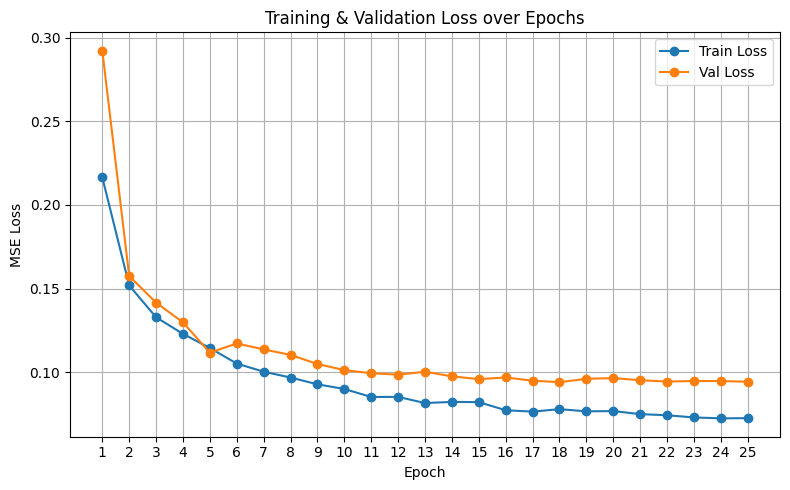

In [29]:
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, '-o', label='Train Loss')
plt.plot(epochs, val_losses,   '-o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss over Epochs')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Download the best model

In [30]:
# Save the model checkpoint to Google Drive
import shutil

shutil.copy('checkpoints/best_uhi.pth', '/content/drive/MyDrive/best_uhi_checkpoint.pth')
print("Model checkpoint copied to Google Drive.")

# Alternatively, download the model checkpoint to your local machine
from google.colab import files
files.download('checkpoints/best_uhi.pth')

Model checkpoint copied to Google Drive.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Save the best model checkpoint

In [31]:
# load best weights
checkpoint = torch.load("checkpoints/best_uhi.pth", map_location=DEVICE)
lst_enc.load_state_dict(checkpoint['lst_enc'])
pm_enc.load_state_dict(checkpoint['pm_enc'])
lc_enc.load_state_dict(checkpoint['lc_enc'])
fusion.load_state_dict(checkpoint['fusion'])
lst_enc.eval(); pm_enc.eval(); lc_enc.eval(); fusion.eval()

FusionAttentionUNet(
  (enc1): Sequential(
    (0): Conv2d(384, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (att2): AttentionGate(
    (W_g): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1,

In [32]:
def run_inference(test_loader, lst_enc, pm_enc, lc_enc, fusion, criterion, device):
    """
    Runs inference on the test_loader and returns:
    - avg_loss: average MSE loss over the test set
    - all_preds: numpy array of shape (N, 1, H, W) of predicted UHI maps
    - all_gts: numpy array of shape (N, 1, H, W) of ground-truth UHI maps
    """
    import torch
    import torch.nn.functional as F

    # set models to eval
    lst_enc.eval()
    pm_enc.eval()
    lc_enc.eval()
    fusion.eval()

    total_loss = 0.0
    all_preds = []
    all_gts = []

    with torch.no_grad():
        for pm25, lst, lc, gt in test_loader:
            pm25, lst, lc, gt = [t.to(device) for t in (pm25, lst, lc, gt)]
            # Encode each modality
            f_pm = pm_enc(pm25)
            f_lst = lst_enc(lst)
            f_lc = lc_enc(lc)
            # Align resolutions if needed
            if f_lc.shape[-2:] != f_pm.shape[-2:]:
                f_lc = F.interpolate(f_lc, size=f_pm.shape[-2:], mode='bilinear', align_corners=False)

            # Fuse & predict at low resolution
            pred_low = fusion(torch.cat([f_pm, f_lst, f_lc], dim=1))
            # Upsample to match ground truth resolution
            pred = F.interpolate(pred_low, size=gt.shape[-2:], mode='bilinear', align_corners=False)

            # Compute loss
            loss = criterion(pred, gt)
            total_loss += loss.item() * pm25.size(0)

            # Store results
            all_preds.append(pred.cpu())
            all_gts.append(gt.cpu())

    avg_loss = total_loss / len(test_loader.dataset)
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_gts = torch.cat(all_gts, dim=0).numpy()

    return avg_loss, all_preds, all_gts

# run on held-out test set
test_mse, preds, gts = run_inference(test_loader,
                                     lst_enc, pm_enc, lc_enc, fusion,
                                     criterion, DEVICE)
import torch.nn.functional as F
test_mae  = F.l1_loss(torch.tensor(preds), torch.tensor(gts)).item()
test_rmse = torch.sqrt(F.mse_loss(torch.tensor(preds), torch.tensor(gts))).item()

print(f"\nTest results — MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}")


Test results — MSE: 0.1020, MAE: 0.1452, RMSE: 0.3194


### Load the best model for any further changes

In [33]:
# Load checkpoint
checkpoint_path = '/content/drive/MyDrive/best_uhi_checkpoint.pth'
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
lst_enc.load_state_dict(checkpoint['lst_enc'])
pm_enc.load_state_dict(checkpoint['pm_enc'])
lc_enc.load_state_dict(checkpoint['lc_enc'])
fusion.load_state_dict(checkpoint['fusion'])

# Set to evaluation mode
lst_enc.eval()
pm_enc.eval()
lc_enc.eval()
fusion.eval()

FusionAttentionUNet(
  (enc1): Sequential(
    (0): Conv2d(384, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (att2): AttentionGate(
    (W_g): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1,

### Testing the Model

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


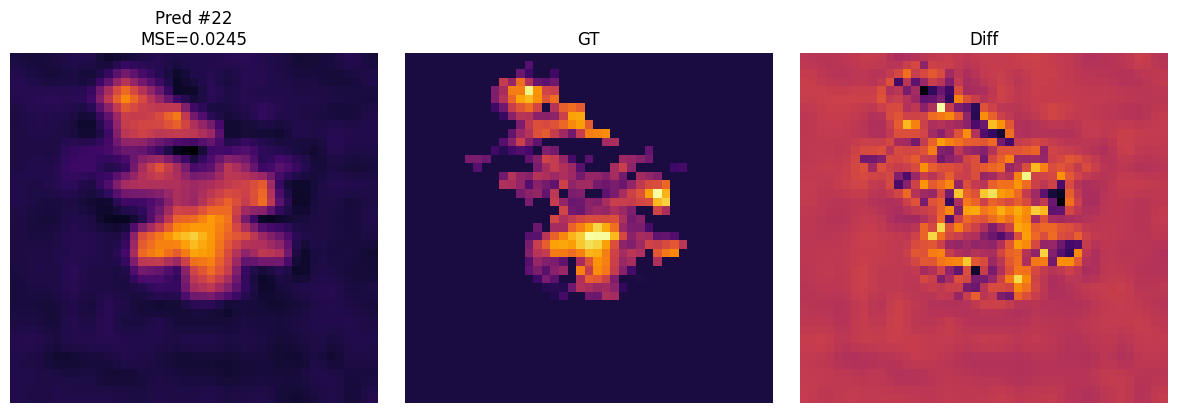

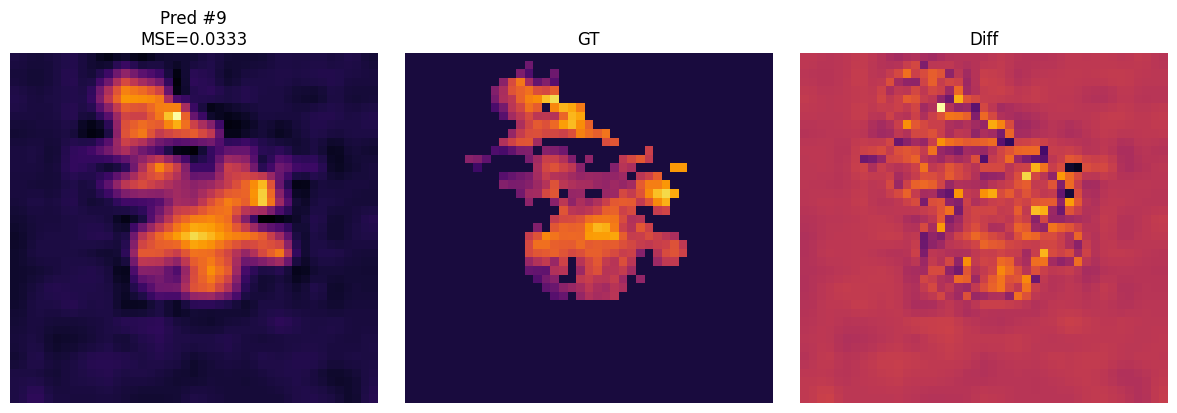

In [35]:
# Run inference
test_mse, preds, gts = run_inference(test_loader, lst_enc, pm_enc, lc_enc, fusion, criterion, DEVICE)

# Per-sample MSE
flat_preds = preds.reshape(preds.shape[0], -1)
flat_gts   = gts.reshape(gts.shape[0],   -1)
sample_mses = np.mean((flat_preds - flat_gts) ** 2, axis=1)
best_idxs = np.argsort(sample_mses)[:2]  # just top 2

plt.rcParams['image.cmap'] = 'inferno'

for idx in best_idxs:
    pred = preds[idx, 0]
    gt   = gts[idx,   0]
    diff = pred - gt

    vmin = min(gt.min(), pred.min())
    vmax = max(gt.max(), pred.max())
    absmax = np.max(np.abs(diff))

    # plot each sample in its own figure
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(pred,  vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Pred #{idx}\nMSE={sample_mses[idx]:.4f}")
    axes[0].axis('off')

    axes[1].imshow(gt, vmin=vmin, vmax=vmax)
    axes[1].set_title("GT")
    axes[1].axis('off')

    axes[2].imshow(diff, vmin=-absmax, vmax=absmax)
    axes[2].set_title("Diff")
    axes[2].axis('off')


    plt.tight_layout()
    plt.show()
    plt.close(fig)


### Model Metrics and Internals

In [36]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

In [37]:
y_true = gts.flatten()
y_pred = preds.flatten()
test_mae  = mean_absolute_error(y_true, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2   = r2_score(y_true, y_pred)

print(f"Test MSE:  {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE:  {test_mae:.4f}")
print(f"Test R²:   {test_r2:.4f}")

Test MSE:  0.1020
Test RMSE: 0.3194
Test MAE:  0.1452
Test R²:   0.6906


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

LST fmap shape: (128, 11, 11)
  min=0.0000, max=2.7011, mean=0.2456


(np.float64(-0.5), np.float64(10.5), np.float64(10.5), np.float64(-0.5))

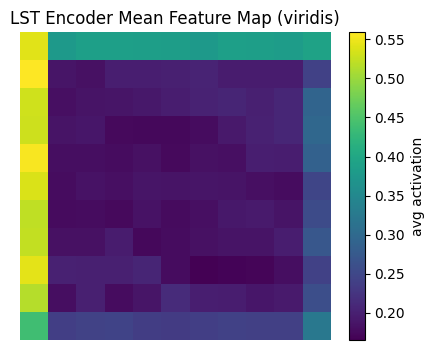

In [39]:
# run a single sample
_, lst, _, _ = test_ds[0]
x = lst.unsqueeze(0).to(DEVICE)

with torch.no_grad():
    # replicate b1→b2→b3 pipeline
    fmap = lst_enc.b3(lst_enc.b2(lst_enc.b1(x))).cpu().squeeze(0)  # (C, H', W')

# numeric summary
print(f"LST fmap shape: {tuple(fmap.shape)}")
print(f"  min={fmap.min():.4f}, max={fmap.max():.4f}, mean={fmap.mean():.4f}")

# channel-mean map
mean_map = fmap.mean(dim=0)
plt.figure(figsize=(5,4))
plt.imshow(mean_map, cmap='viridis', aspect='auto')
plt.colorbar(label='avg activation')
plt.title('LST Encoder Mean Feature Map (viridis)')
plt.axis('off')

PM2.5 fmap shape: (128, 11, 11)
  min=0.0000, max=4.9937, mean=0.3757


(np.float64(-0.5), np.float64(10.5), np.float64(10.5), np.float64(-0.5))

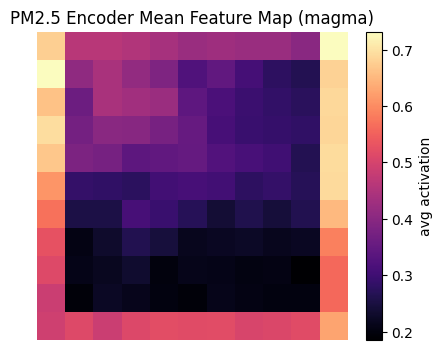

In [40]:
# %% Snippet 2: PM2.5 Encoder Feature–Mean (magma)
pm25, _, _, _ = test_ds[0]
x = pm25.unsqueeze(0).to(DEVICE)

with torch.no_grad():
    fmap = pm_enc.b3(pm_enc.b2(pm_enc.b1(x))).cpu().squeeze(0)

print(f"PM2.5 fmap shape: {tuple(fmap.shape)}")
print(f"  min={fmap.min():.4f}, max={fmap.max():.4f}, mean={fmap.mean():.4f}")

mean_map = fmap.mean(dim=0)
plt.figure(figsize=(5,4))
plt.imshow(mean_map, cmap='magma', aspect='auto')
plt.colorbar(label='avg activation')
plt.title('PM2.5 Encoder Mean Feature Map (magma)')
plt.axis('off')

LC fmap shape: (128, 334, 351)
  min=0.0000, max=3.8342, mean=0.0268


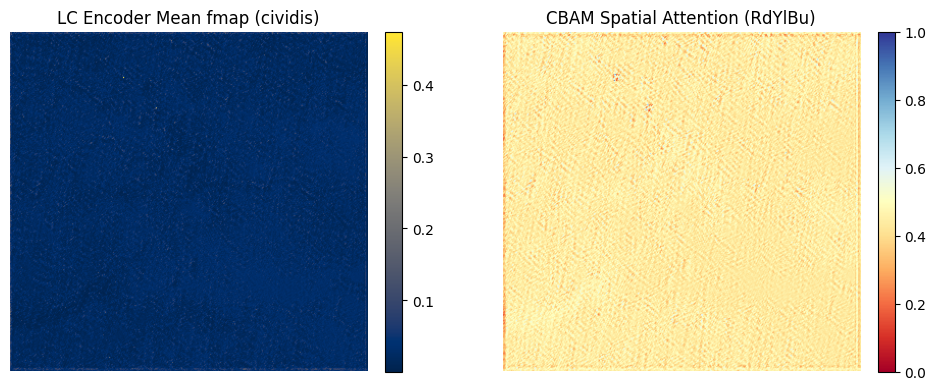

In [50]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Grab sample
_, _, lc, _ = test_ds[0]
x = lc.unsqueeze(0).to(DEVICE)

# Hook to capture CBAM spatial mask
cbam_map = {}
def cbam_hook(m, inp, out):
    pool_cat = torch.cat([out.mean(1,keepdim=True), out.max(1,keepdim=True)[0]], dim=1)
    cbam_map['spat'] = torch.sigmoid(m.conv_spatial(pool_cat)).cpu().squeeze().numpy()

h = lc_enc.cbam.register_forward_hook(cbam_hook)

with torch.no_grad():
    fmap = lc_enc(x).cpu().squeeze(0)  # (C, H'', W'')

h.remove()

print(f"LC fmap shape: {tuple(fmap.shape)}")
print(f"  min={fmap.min():.4f}, max={fmap.max():.4f}, mean={fmap.mean():.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Feature activations
im1 = ax1.imshow(fmap.mean(0), cmap='cividis')
ax1.set_title('LC Encoder Mean fmap (cividis)')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# CBAM spatial
im2 = ax2.imshow(cbam_map['spat'], cmap='RdYlBu', vmin=0, vmax=1)
ax2.set_title('CBAM Spatial Attention (RdYlBu)')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

att2 shape: (5, 5), min=0.1649, max=0.8737


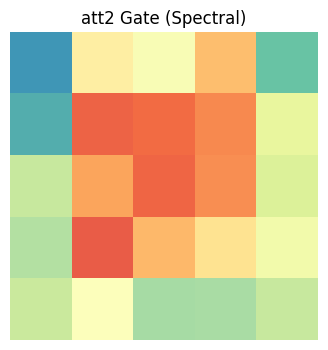

att1 shape: (11, 11), min=0.2350, max=0.9774


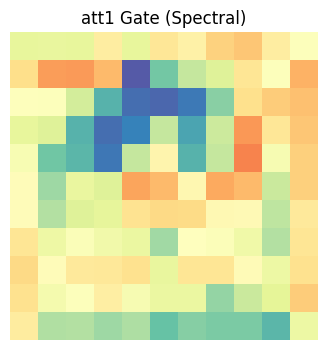

In [46]:
from collections import OrderedDict

# Ensure _forward_hooks is an OrderedDict for both modules
fusion.att2.psi._forward_hooks = OrderedDict()
fusion.att1.psi._forward_hooks = OrderedDict()

# Define the hook function
def hook(name):
    def _hook(m, inp, out):
        if isinstance(out, torch.Tensor):
            feature_maps[name] = out.detach().cpu().squeeze().numpy()
        else:
            print(f"Unexpected type for out in {name}: {type(out)}")
    return _hook

# Register the hooks
fusion.att2.psi.register_forward_hook(hook('att2'))
fusion.att1.psi.register_forward_hook(hook('att1'))

# Proceed with the forward pass
pm25, lst, lc, _ = test_ds[0]
with torch.no_grad():
    f_pm = pm_enc(pm25.unsqueeze(0).to(DEVICE))
    f_lst = lst_enc(lst.unsqueeze(0).to(DEVICE))
    f_lc = lc_enc(lc.unsqueeze(0).to(DEVICE))
    if f_lc.shape[-2:] != f_pm.shape[-2:]:
        f_lc = F.interpolate(f_lc, size=f_pm.shape[-2:], mode='bilinear', align_corners=False)
    _ = fusion(torch.cat([f_pm, f_lst, f_lc], dim=1))

# Visualize the captured feature maps
for name, arr in feature_maps.items():
    print(f"{name} shape: {arr.shape}, min={arr.min():.4f}, max={arr.max():.4f}")
    plt.figure(figsize=(4, 4))
    plt.imshow(arr, cmap='Spectral', vmin=0, vmax=1)
    plt.title(f"{name} Gate (Spectral)")
    plt.axis('off')
    plt.show()

Embedding stats: mean=-0.0521, std=1.0481


(np.float64(6.32082233428955),
 np.float64(8.71824779510498),
 np.float64(4.541701245307922),
 np.float64(6.637583327293396))

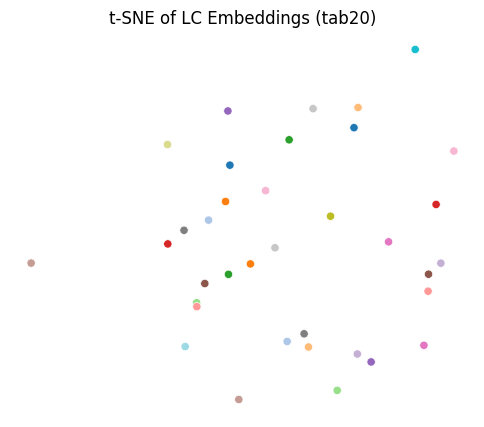

In [47]:
# %% Snippet 5: LC Embedding t-SNE (tab20)
import seaborn as sns
from sklearn.manifold import TSNE

emb = lc_enc.embed.weight.data[1:].cpu().numpy()  # (36, dim)
print(f"Embedding stats: mean={emb.mean():.4f}, std={emb.std():.4f}")

pts = TSNE(n_components=2, random_state=42).fit_transform(emb)
plt.figure(figsize=(6,5))
sns.scatterplot(x=pts[:,0], y=pts[:,1],
                palette='tab20', hue=list(range(1,37)), legend=False)
plt.title('t-SNE of LC Embeddings (tab20)')
plt.axis('off')

Embedding stats: mean=-0.0521, std=1.0481


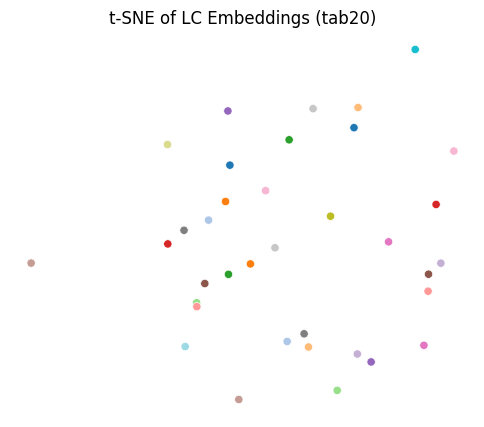

In [52]:
# Extract embeddings
emb = lc_enc.embed.weight.data[1:].cpu().numpy()  # (36, dim)
print(f"Embedding stats: mean={emb.mean():.4f}, std={emb.std():.4f}")

# Compute t-SNE
pts = TSNE(n_components=2, random_state=42).fit_transform(emb)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=pts[:,0], y=pts[:,1],
                palette='tab20', hue=list(range(1, 37)), legend=False)
plt.title('t-SNE of LC Embeddings (tab20)')
plt.axis('off')
plt.show()

Text(35.22222222222222, 0.5, 'class idx')

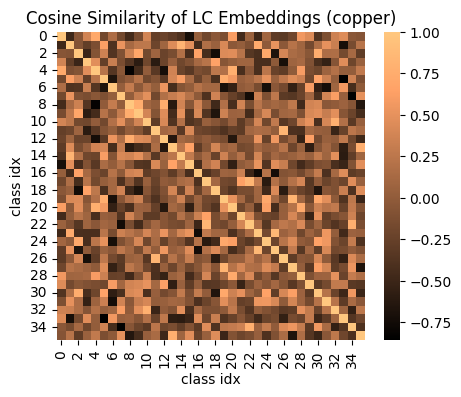

In [48]:
# %% Snippet 6: Cosine-Similarity Heatmap (copper)
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(emb)
plt.figure(figsize=(5,4))
sns.heatmap(sim, cmap='copper', square=True)
plt.title('Cosine Similarity of LC Embeddings (copper)')
plt.xlabel('class idx'); plt.ylabel('class idx')

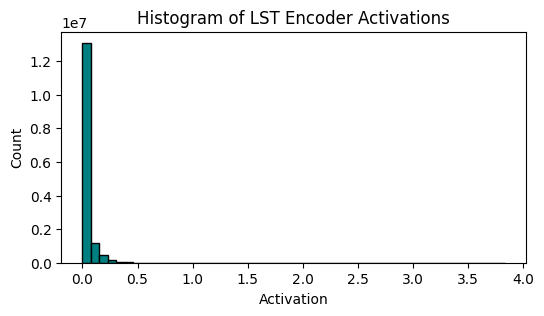

In [49]:
# %% Snippet 7: Histogram of LST Enc fmap activations (coolwarm)
fmap_flat = fmap.flatten()
plt.figure(figsize=(6,3))
plt.hist(fmap_flat, bins=50, color='teal', edgecolor='black')
plt.title('Histogram of LST Encoder Activations')
plt.xlabel('Activation'); plt.ylabel('Count')
plt.show()